# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

2024-04-15 12:41:45.041721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:41:45.041754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:41:45.042295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 12:41:45.047083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [2]:
from MachineLearningUtils.system_setup.gpu import activate_gpu
activate_gpu()

1 Physical GPUs, 1 Logical GPU


2024-04-15 12:41:46.622425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 12:41:46.657308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 12:41:46.657653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Video N°183: Getting helper functions ready and downloading data to model

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [3]:
# Import series of helper functions for our notebook
from MachineLearningUtils.data_acquisition.data_downloader import *
from MachineLearningUtils.data_visualization.augmentation_effects import *
from MachineLearningUtils.data_visualization.evaluation_metrics import *
from MachineLearningUtils.data_visualization.image_visualization import *
from MachineLearningUtils.data_visualization.model_learning_curves import *
from MachineLearningUtils.data_visualization.prediction_visualization import *
from MachineLearningUtils.training_utilities.model_callbacks import *
from MachineLearningUtils.training_utilities.transfer_learning import *

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/image_data_modification.ipynb

In [4]:
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
download_data(url=url, file_path="101_food_classes_10_percent.zip", extract=True)

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

The file 101_food_classes_10_percent.zip already exists.
Extracting 101_food_classes_10_percent.zip as ZIP...
101_food_classes_10_percent.zip has been extracted to current directory.


In [5]:
# How many images/classes are there?
walk_through_dir(dir_path="101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_

In [6]:
# Args for image_dataset_from_directory
idfd_args={
    "image_size":(224, 224),
    "label_mode":"categorical",
    "batch_size":32
}

In [7]:
# Setup data inputs
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                **idfd_args)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Video N°184: Outlining the model we're going to build and building a ModelCheckpoint callback

## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

Video N°185: Creating a data augmentation layer to use with our model

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1./255) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

Video N°186: Creating a headless EfficientNetB0 model with data augmentation built in

Rappel:
#159: Note: Fixes for EfficientNetB0 model creation + weight loading
**Old:**
```python
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
```
**New:**
```python
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
```

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode se weights wich need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

Video N°187: Fitting and evaluating our biggest transfer learning model yet

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5


2024-04-12 19:45:58.266319: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-12 19:46:00.251576: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd548afdd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 19:46:00.251615: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-04-12 19:46:00.260354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712943960.396755   36781 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 343s 1s/step - loss: 3.5343 - accuracy: 0.2363 - val_loss: 2.6686 - val_accuracy: 0.4216
Epoch 2/5
237/237 [==============================] - 262s 1s/step - loss: 2.4349 - accuracy: 0.4432 - val_loss: 2.1580 - val_accuracy: 0.4950
Epoch 3/5
237/237 [==============================] - 225s 945ms/step - loss: 2.0435 - accuracy: 0.5180 - val_loss: 2.0294 - val_accuracy: 0.4934
Epoch 4/5
237/237 [==============================] - 186s 786ms/step - loss: 1.8406 - accuracy: 0.5547 - val_loss: 1.9108 - val_accuracy: 0.5233
Epoch 5/5
237/237 [==============================] - 172s 727ms/step - loss: 1.6869 - accuracy: 0.5864 - val_loss: 1.8678 - val_accuracy: 0.5185


In [26]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 43s 55ms/step - loss: 1.8266 - accuracy: 0.6088


[1.8266297578811646, 0.6087524890899658]

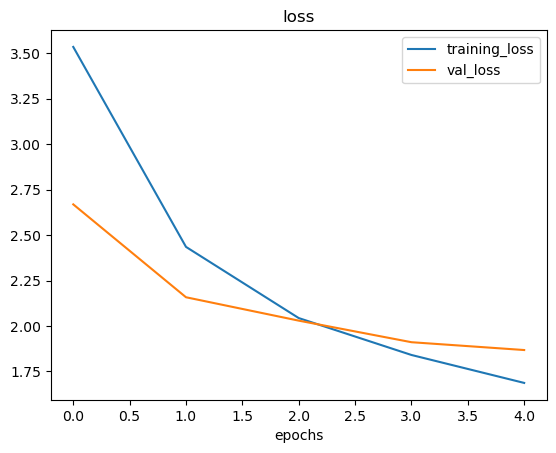

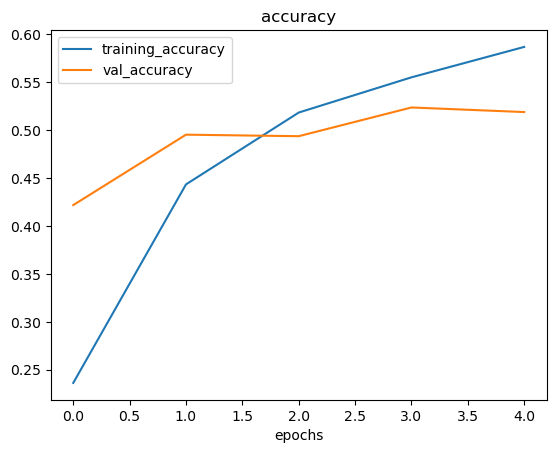

In [15]:
plot_loss_curves(history=history_all_classes_10_percent)

> **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

Video N°188: Unfreezing some layers in our base model to prepare for fine-tuning

## Fine-tuning

In [16]:
configure_trainable_layers(model=model, n_trainable_layers=5, verbose=True)

Layer 1: input_layer, Trainable: True
Layer 2: data_augmentation, Trainable: True
Layer 3: efficientnetv2-b0, Trainable: True
Layer 4: global_avg_pool_layer, Trainable: True
Layer 5: output_layer, Trainable: True


In [17]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool_layer True
output_layer True


In [19]:
# Check which layers are traiable in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_activ

Video N°189: Fine-tuning our feature extraction model and evaluating its performance

In [23]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 1219s 5s/step - loss: 1.3371 - accuracy: 0.6436 - val_loss: 1.6012 - val_accuracy: 0.5877
Epoch 6/10
237/237 [==============================] - 772s 3s/step - loss: 1.0191 - accuracy: 0.7224 - val_loss: 1.6550 - val_accuracy: 0.5697
Epoch 7/10
237/237 [==============================] - 599s 3s/step - loss: 0.7732 - accuracy: 0.7824 - val_loss: 1.7248 - val_accuracy: 0.5596
Epoch 8/10
237/237 [==============================] - 554s 2s/step - loss: 0.5527 - accuracy: 0.8395 - val_loss: 1.9618 - val_accuracy: 0.5320
Epoch 9/10
237/237 [==============================] - 417s 2s/step - loss: 0.4150 - accuracy: 0.8804 - val_loss: 1.9841 - val_accuracy: 0.5665
Epoch 10/10
237/237 [==============================] - 375s 2s/step - loss: 0.3150 - accuracy: 0.9050 - val_loss: 1.9947 - val_accuracy: 0.5726


In [24]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 49s 62ms/step - loss: 1.8266 - accuracy: 0.6088


[1.8266297578811646, 0.6087524890899658]

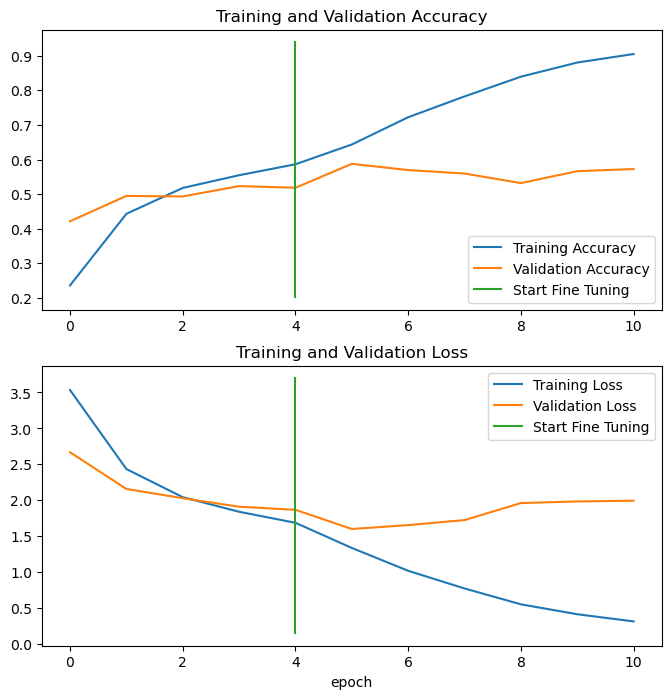

In [25]:
# Compare the histories of feature extraction model with fine-tuning model
compare_histories(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

Video N°190: Saving and loading our trained model

## Saving and loading our model

To use our model in an external application we'll need to save it and export it somewhere.

In [8]:
big_dog_model_name = "101_food_classes_10_percent_saved_big_dog_model" 

In [27]:
# Save our fine-tuning model
model.save(filepath=big_dog_model_name)

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


> 🔑 **Note:** Loading the model with the following cell will output a large amount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [9]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model(filepath=big_dog_model_name)

In [10]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

2024-04-15 10:22:38.056033: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


790/790 [==============================] - 62s 74ms/step - loss: 1.8266 - accuracy: 0.6088


[1.8266297578811646, 0.6087524890899658]

In [ ]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

Video N°191: Downloading a pretrained model to make and evaluate predictions with

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [11]:
# Download pretrained model (one that was prepared earlier, so all predictions are similar)
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"
download_data(url=url, file_path="06_101_food_class_10_percent_saved_big_dog_model.zip", extract=True)

The file 06_101_food_class_10_percent_saved_big_dog_model.zip already exists.
Extracting 06_101_food_class_10_percent_saved_big_dog_model.zip as ZIP...
06_101_food_class_10_percent_saved_big_dog_model.zip has been extracted to current directory.


In [10]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [26]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 65s 82ms/step - loss: 1.8027 - accuracy: 0.6078


[1.802719235420227, 0.6077623963356018]

Video N°192: Making predictions with our trained model on 25250 test  samples

## Making predictions with our trained model

In [11]:
# Make predictions with model
# NB: test_data must be the same format as the one used to train the model. Example (224, 224, 3)
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left
preds_probs

2024-04-15 12:43:35.973815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


790/790 [==============================] - 68s 83ms/step


array([[5.9542075e-02, 3.5742519e-06, 4.1377105e-02, ..., 1.4138838e-09,
        8.3531369e-05, 3.0897786e-03],
       [9.6401703e-01, 1.3753144e-09, 8.4778655e-04, ..., 5.4285505e-05,
        7.8361935e-12, 9.8465291e-10],
       [9.5925927e-01, 3.2534070e-05, 1.4866914e-03, ..., 7.1889457e-07,
        5.4399629e-07, 4.0275565e-05],
       ...,
       [1.5138710e-05, 4.0972949e-04, 8.0249551e-10, ..., 2.1742768e-05,
        1.0797297e-05, 5.3789866e-01],
       [5.9318044e-03, 4.9236827e-03, 9.9822693e-03, ..., 1.1989535e-04,
        1.6890313e-05, 4.5218010e-02],
       [3.1363595e-02, 7.5052613e-03, 4.2974955e-04, ..., 5.0346559e-04,
        5.2056807e-06, 6.9062763e-01]], dtype=float32)

In [12]:
len(test_data)

790

In [13]:
# How many predictions are there?
len(preds_probs)

25250

In [14]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [15]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542075e-02, 3.5742519e-06, 4.1377105e-02, ..., 1.4138838e-09,
        8.3531369e-05, 3.0897786e-03],
       [9.6401703e-01, 1.3753144e-09, 8.4778655e-04, ..., 5.4285505e-05,
        7.8361935e-12, 9.8465291e-10],
       [9.5925927e-01, 3.2534070e-05, 1.4866914e-03, ..., 7.1889457e-07,
        5.4399629e-07, 4.0275565e-05],
       ...,
       [4.7313046e-01, 1.2931298e-07, 1.4805519e-03, ..., 5.9749861e-04,
        6.6969042e-05, 2.3469616e-05],
       [4.4572026e-02, 4.7265883e-07, 1.2258436e-01, ..., 6.3498255e-06,
        7.5319513e-06, 3.6778969e-03],
       [7.2438651e-01, 1.9249835e-09, 5.2311112e-05, ..., 1.2291525e-03,
        1.5792978e-09, 9.6396252e-05]], dtype=float32)

In [16]:
# What does the first prediction probability array look like?
preds_probs[0]

array([5.9542075e-02, 3.5742519e-06, 4.1377105e-02, 1.0660675e-09,
       8.1614733e-09, 8.6640455e-09, 8.0927953e-07, 8.5652562e-07,
       1.9859333e-05, 8.0978435e-07, 3.1727978e-09, 9.8674286e-07,
       2.8532467e-04, 7.8050066e-10, 7.4230676e-04, 3.8916518e-05,
       6.4741098e-06, 2.4977680e-06, 3.7891088e-05, 2.0678442e-07,
       1.5538551e-05, 8.1508250e-07, 2.6230564e-06, 2.0010719e-07,
       8.3828002e-07, 5.4216125e-06, 3.7391171e-06, 1.3150555e-08,
       2.7761464e-03, 2.8052071e-05, 6.8562794e-10, 2.5574898e-05,
       1.6689053e-04, 7.6408008e-10, 4.0453312e-04, 1.3150755e-08,
       1.7957562e-06, 1.4448336e-06, 2.3062818e-02, 8.2467471e-07,
       8.5365667e-07, 1.7138624e-06, 7.0525689e-06, 1.8402268e-08,
       2.8553313e-07, 7.9485108e-06, 2.0681648e-06, 1.8525253e-07,
       3.3620083e-08, 3.1522411e-04, 1.0410940e-05, 8.5448261e-07,
       8.4741843e-01, 1.0555443e-05, 4.4094534e-07, 3.7404097e-05,
       3.5306184e-05, 3.2489246e-05, 6.7315115e-05, 1.2852638e

In [17]:
len(preds_probs[0]), sum(preds_probs[0])

(101, 1.0000000628516963)

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [18]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542075e-02 3.5742519e-06 4.1377105e-02 1.0660675e-09 8.1614733e-09
 8.6640455e-09 8.0927953e-07 8.5652562e-07 1.9859333e-05 8.0978435e-07
 3.1727978e-09 9.8674286e-07 2.8532467e-04 7.8050066e-10 7.4230676e-04
 3.8916518e-05 6.4741098e-06 2.4977680e-06 3.7891088e-05 2.0678442e-07
 1.5538551e-05 8.1508250e-07 2.6230564e-06 2.0010719e-07 8.3828002e-07
 5.4216125e-06 3.7391171e-06 1.3150555e-08 2.7761464e-03 2.8052071e-05
 6.8562794e-10 2.5574898e-05 1.6689053e-04 7.6408008e-10 4.0453312e-04
 1.3150755e-08 1.7957562e-06 1.4448336e-06 2.3062818e-02 8.2467471e-07
 8.5365667e-07 1.7138624e-06 7.0525689e-06 1.8402268e-08 2.8553313e-07
 7.9485108e-06 2.0681648e-06 1.8525253e-07 3.3620083e-08 3.1522411e-04
 1.0410940e-05 8.5448261e-07 8.4741843e-01 1.0555443e-05 4.4094534e-07
 3.7404097e-05 3.5306184e-05 3.2489246e-05 6.7315115e-05 1.2852638e-08
 2.6219701e-10 1.0318226e-05 8.5743530e-05 1.

In [19]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [20]:
# How many pred classes do we have?
len(pred_classes)

25250

Video N°193: Unravelling our test dataset for comparing ground truth labels to predictions

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [21]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the \"1\" occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
# How many y_labels are there?
len(y_labels)

25250

In [23]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

Video N°194: Confirming our model's predictions are in the same order as the test labels

## Evaluating our model's predictions

One way to check that our model's predictions array (`pred_classes`) is in the same order as our test labels array (`y_labels`) is to find the accuracy score.

In [27]:
results_downloaded_model

[1.802719235420227, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

In [ ]:
# Does this metric come close to our model's evaluate results
np.isclose(results_downloaded_model[1], sklearn_accuracy)

Video N°195: Creating a confusion matrix for our model's 101 different classes

## Let's get visual: making a confusion matrix

In [28]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [29]:
len(y_labels), len(pred_classes)

(25250, 25250)

In [30]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_names, figsize=(100, 100), text_size=20, savefig=True, xlabels_rotation=90)

Video N°196: Evaluating every individual class in our dataset

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [32]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

Let's plot all of our classes F1-scores...

In [36]:
totals_list = ['accuracy', 'macro avg', 'weighted avg']
class_f1_scores = {}
for k, v in classification_report_dict.items():
    if k not in totals_list: # k.isdigit():
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5440806045340051,
 'beet_salad': 0.4186046511627907,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056105,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46255506607929514,
 'creme_brulee'

In [60]:
class ClassificationReportProcessor:
    def __init__(self, y_true, y_pred, class_names=None):
        """
        Initialize with true and predicted labels.
        Generates a classification report in dictionary format.

        Parameters:
        y_true (array-like): True labels of the dataset.
        y_pred (array-like): Predicted labels by the classifier.
        """
        # Todo: include class_names !!!
        self.report = classification_report(y_true, y_pred, output_dict=True)

    def get_class_report(self, class_name):
        """
        Retrieve the classification metrics for a given class.

        Parameters:
        class_name (str): The class name to retrieve the report for.

        Returns:
        dict: A dictionary of classification metrics for the specified class, or a message if the class is not found.
        """
        return self.report.get(str(class_name), "Class not found")

    def f1_scores(self):
        """
        Returns a dictionary of f1-scores for all classes.

        Returns:
        dict: Dictionary with class names as keys and f1-scores as values.
        """
        return {class_name: info['f1-score'] for class_name, info in self.report.items() if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

    def precisions(self):
        """
        Returns a dictionary of precisions for all classes.

        Returns:
        dict: Dictionary with class names as keys and precisions as values.
        """
        return {class_name: info['precision'] for class_name, info in self.report.items() if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

    def recalls(self):
        """
        Returns a dictionary of recalls for all classes.

        Returns:
        dict: Dictionary with class names as keys and recalls as values.
        """
        return {class_name: info['recall'] for class_name, info in self.report.items() if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

    def supports(self):
        """
        Returns a dictionary of supports for all classes.

        Returns:
        dict: Dictionary with class names as keys and support numbers as values.
        """
        return {class_name: info['support'] for class_name, info in self.report.items() if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

    def average_precision(self):
        """
        Calculate the weighted average precision across all classes.

        Returns:
        float: Weighted average precision.
        """
        return self.report['weighted avg']['precision']

    def average_recall(self):
        """
        Calculate the weighted average recall across all classes.

        Returns:
        float: Weighted average recall.
        """
        return self.report['weighted avg']['recall']

    def average_f1_score(self):
        """
        Calculate the weighted average f1-score across all classes.

        Returns:
        float: Weighted average f1-score.
        """
        return self.report['weighted avg']['f1-score']

    def total_support(self):
        """
        Sum the support across all classes, which corresponds to the total number of samples.

        Returns:
        int: Total number of samples (support).
        """
        return sum(class_info['support'] for class_name, class_info in self.report.items() if class_name not in ['accuracy', 'macro avg', 'weighted avg'])

In [61]:
crp = ClassificationReportProcessor(y_true=y_labels, y_pred=pred_classes)

In [62]:
crp.average_f1_score()

0.6061252197245781

In [63]:
crp.f1_scores()

{'0': 0.24056603773584906,
 '1': 0.5864406779661017,
 '2': 0.6022304832713755,
 '3': 0.616822429906542,
 '4': 0.5440806045340051,
 '5': 0.4186046511627907,
 '6': 0.7229357798165138,
 '7': 0.7908902691511387,
 '8': 0.3866943866943867,
 '9': 0.5117370892018779,
 '10': 0.5047619047619047,
 '11': 0.6161616161616161,
 '12': 0.6105610561056105,
 '13': 0.5775193798449613,
 '14': 0.574757281553398,
 '15': 0.3674418604651163,
 '16': 0.5654135338345865,
 '17': 0.42546063651591287,
 '18': 0.5008403361344538,
 '19': 0.6411889596602972,
 '20': 0.7123809523809523,
 '21': 0.4526166902404526,
 '22': 0.3291592128801431,
 '23': 0.7134935304990758,
 '24': 0.7708779443254818,
 '25': 0.734020618556701,
 '26': 0.46255506607929514,
 '27': 0.7494824016563147,
 '28': 0.6935483870967742,
 '29': 0.6910569105691057,
 '30': 0.7476190476190476,
 '31': 0.7357293868921776,
 '32': 0.7855787476280834,
 '33': 0.9371428571428572,
 '34': 0.7238805970149254,
 '35': 0.7158351409978309,
 '36': 0.5475728155339806,
 '37': 0.38